To use Padé approximants for approximating sin (x), first find the Taylor series of sin (x) around x=0, then equate it to a rational function P(x)/Q(x) where P(x) and Q(x) are polynomials with Q(x)'s constant term being 1

In [10]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import math
import time

build Taylor coefficients for sin(x) i choose a higher degree for the taylor order to have the approximation
fit sinx better for longer

In [2]:
N = 14 # total taylor order (degrees for P and Q will be half this)
coeffs = [0.0] * (N + 1)   
# forming the taylor series
for n in range(N + 1):
    if n % 2 == 1:  # this makes only odd powers have none zeros
        coeffs[n] = ((-1) ** ((n - 1) // 2)) / math.factorial(n)
    else:
        coeffs[n] = 0.0

In [3]:
start = time.perf_counter()
m = 7  # the degree for P and Q
p_poly, q_poly = interpolate.pade(coeffs, m)
# do research on how the coefficients are written and make a for loop for this and make a comparison as well


print("Numerator polynomial P(x):", p_poly)   
print("Denominator polynomial Q(x):", q_poly)

# P_poly and Q_poly come back as arrays this turns them into a callable function
p = np.poly1d(p_poly) 
q = np.poly1d(q_poly)

def pade_eval(x):
    denom = q(x)
    safe = np.abs(denom) > 1e-12 # avoids divide by zero
    y = np.full_like(x, np.nan, dtype=float) 
    # ^^ Creates an array y the same shape as x, filled with not-a-number to 
    # avoid unsafe values that might divide by zero
    y[safe] = p(x[safe]) / denom[safe] # only evaluate P(x)/Q(x) at safe positions
    return y # gives the safe values and the NaN
end = time.perf_counter()

Numerator polynomial P(x):             7            5          3
-4.163e-05 x + 0.004586 x - 0.1425 x + 1 x
Denominator polynomial Q(x):            6             4           2
1.595e-06 x + 0.0002761 x + 0.02414 x + 1


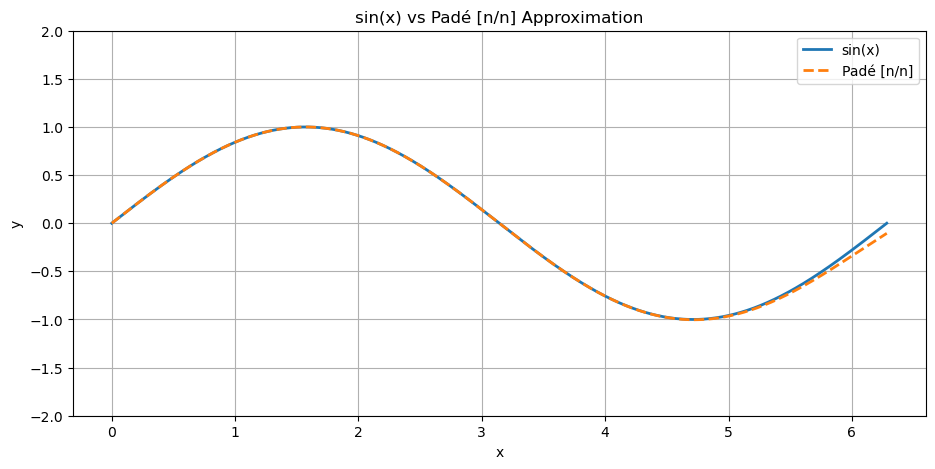

Time for one call: 0.04995090 seconds
Mean Absolute Error: 7.999635e-03
Root Mean Square Error: 2.107252e-02
Max Absolute Error: 1.050387e-01
Min Absolute Error: 0.000000e+00


In [4]:
#This is the 0,2pi range the project asks for but it doesnt  show how pade's accuracy starts to 
# fail on the left side of the graph on the negative side as well as the positive  

x_vals = np.linspace(0, 2 * np.pi, 2000)
y_sin = np.sin(x_vals)
y_pade = pade_eval(x_vals)

abs_error = np.abs(y_sin - y_pade)
mean_abs_err = np.mean(abs_error)
root_mean_squ_err = np.sqrt(np.mean((y_sin - y_pade)**2))
max_error = np.max(abs_error)
min_error = np.min(abs_error)


plt.figure(figsize=(11,5))
plt.plot(x_vals, y_sin, label='sin(x)', linewidth=2)
plt.plot(x_vals, y_pade, '--', label='Padé [n/n]', linewidth=2)
plt.title('sin(x) vs Padé [n/n] Approximation')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.ylim(-2, 2)
plt.show()
print(f"Time for one call: {end - start:.8f} seconds")
print(f"Mean Absolute Error: {mean_abs_err:.6e}")
print(f"Root Mean Square Error: {root_mean_squ_err:.6e}")
print(f"Max Absolute Error: {max_error:.6e}")
print(f"Min Absolute Error: {min_error:.6e}")

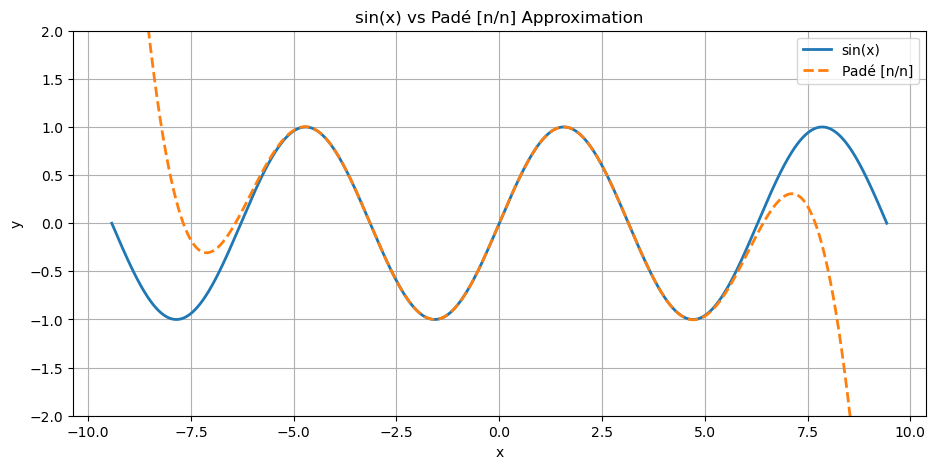

Time for one call: 0.04995090 seconds
Mean Absolute Error: 6.613732e-01
Root Mean Square Error: 1.570795e+00
Max Absolute Error: 6.816235e+00
Min Absolute Error: 0.000000e+00


In [5]:
# this is to show how the pade approx looks on both sides to understand better what its doing and how it functions

x_vals = np.linspace(-3 * np.pi, 3 * np.pi, 2000)
y_sin = np.sin(x_vals)
y_pade = pade_eval(x_vals)

abs_error = np.abs(y_sin - y_pade)
mean_abs_err = np.mean(abs_error)
root_mean_squ_err = np.sqrt(np.mean((y_sin - y_pade)**2))
max_error = np.max(abs_error)
min_error = np.min(abs_error)


plt.figure(figsize=(11,5))
plt.plot(x_vals, y_sin, label='sin(x)', linewidth=2)
plt.plot(x_vals, y_pade, '--', label='Padé [n/n]', linewidth=2)
plt.title('sin(x) vs Padé [n/n] Approximation')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.ylim(-2, 2)
plt.show()
print(f"Time for one call: {end - start:.8f} seconds")
print(f"Mean Absolute Error: {mean_abs_err:.6e}")
print(f"Root Mean Square Error: {root_mean_squ_err:.6e}")
print(f"Max Absolute Error: {max_error:.6e}")
print(f"Min Absolute Error: {min_error:.6e}")

# Below is a quick recreation with the pade constructed manually 

In [6]:
def build_pade_approx(f, v, p_order, q_order, center=0):
    """Constructs the [p_order/q_order] Padé approximant around x=center."""
    
    # Truncated Taylor expansion up to order p+q
    taylor_series = sp.series(f, v, center, p_order + q_order + 1).removeO()
    
    # Symbolic coefficients for numerator and denominator
    p_coeffs = sp.symbols(f'p0:{p_order+1}')
    q_coeffs = sp.symbols(f'q1:{q_order+1}')  # q0 is fixed to 1
    
    # Build numerator P(t) and denominator Q(t)
    P_poly = sum(p_coeffs[i] * (v - center)**i for i in range(p_order + 1))
    Q_poly = 1 + sum(q_coeffs[j-1] * (v - center)**j for j in range(1, q_order + 1))
    
    # Ensure Q*series - P vanishes up to order p+q
    residual = sp.expand(Q_poly * taylor_series - P_poly)
    equations = [residual.expand().coeff(v - center, k) for k in range(p_order + q_order + 1)]
    
    # Solve for coefficients
    solution = sp.solve(equations, list(p_coeffs) + list(q_coeffs))
    
    # Substitute solved coefficients back
    P_final = P_poly.subs(solution)
    Q_final = Q_poly.subs(solution)
    
    # Return simplified rational function
    return sp.simplify(P_final / Q_final)

In [11]:
# --- Build the Padé approximant ---
t = sp.Symbol('t')
func = sp.sin(t)
p_order = q_order = 4  # Example: [4/4] approximant

pade_rational = build_pade_approx(func, t, p_order, q_order)
pade_func = sp.lambdify(t, pade_rational, 'numpy')

# --- Evaluate and compare numerically ---
t_points = np.linspace(-3 * np.pi, 3 * np.pi, 2000)
true_vals = np.sin(t_points)

start_time = time.time()
approx_vals = pade_func(t_points)
end_time = time.time()


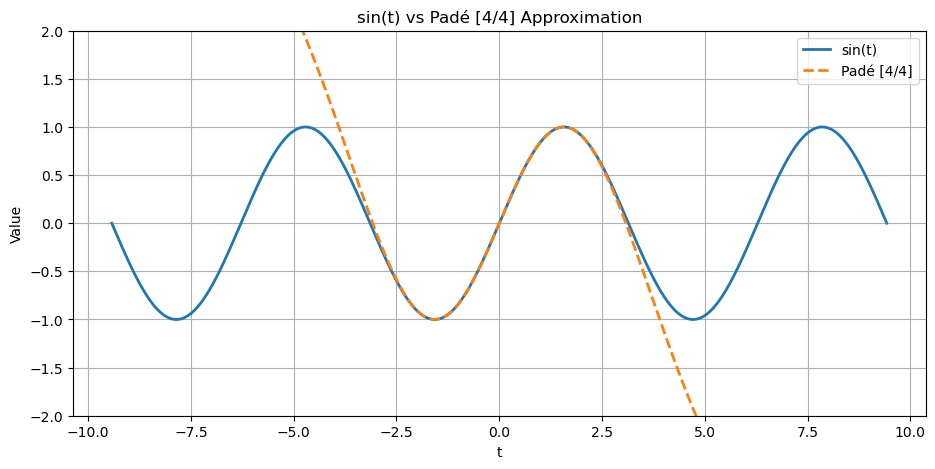

Time for one call: 0.00020790 seconds
Mean Absolute Error: 1.795934e+00
Root Mean Square Error: 2.587426e+00
Max Absolute Error: 4.644672e+00
Min Absolute Error: 0.000000e+00


In [12]:
abs_diff = np.abs(true_vals - approx_vals)
mean_abs_diff = np.mean(abs_diff)
rms_diff = np.sqrt(np.mean(abs_diff**2))
max_diff = np.max(abs_diff)
min_diff = np.min(abs_diff)

# Plot comparison
plt.figure(figsize=(11, 5))
plt.plot(t_points, true_vals, label='sin(t)', linewidth=2)
plt.plot(t_points, approx_vals, '--', label=f'Padé [{p_order}/{q_order}]', linewidth=2)
plt.title(f'sin(t) vs Padé [{p_order}/{q_order}] Approximation')
plt.xlabel('t')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.ylim(-2, 2)
plt.show()

# Print results 
print(f"Time for one call: {end_time - start_time:.8f} seconds")
print(f"Mean Absolute Error: {mean_abs_diff:.6e}")
print(f"Root Mean Square Error: {rms_diff:.6e}")
print(f"Max Absolute Error: {max_diff:.6e}")
print(f"Min Absolute Error: {min_diff:.6e}")